In [3]:
import pinecone
import os
from openai import OpenAI
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict, Optional
from pinecone import Pinecone, ServerlessSpec
from dotenv import load_dotenv


load_dotenv()


# You need to manually set this environment variable in Colab.
# Set environment variables

os.environ["PINECONE_API_KEY"] =os.getenv("PINECONE_API_KEY")
os.environ["PINECONE_ENV"] = os.getenv("PINECONE_ENV")
os.environ["OPENAI_API_KEY"] =os.getenv("OPENAI_API_KEY")

api_key = os.getenv("OPENAI_API_KEY")

# Initialize OpenAI client
client = OpenAI(api_key=api_key)

pc = Pinecone(
        api_key=os.getenv("PINECONE_API_KEY"),
        environment=os.getenv("PINECONE_ENV")
    )

dimension = 1536  # Dimension for OpenAI embeddings
index_name="user-preferences"
    # Check if the index exists; if not, create it
if index_name not in pc.list_indexes():
        pc.create_index(
            name=index_name,
            dimension=dimension,
            metric="cosine",
            spec=ServerlessSpec(
                cloud="aws",
                region=os.environ.get("PINECONE_ENV")  # Use the environment variable
            )
        )
index = pc.Index(index_name)
# Define State
class State(TypedDict):
    user_id: str
    runtime_preference: Optional[str]  # User can provide preference at runtime
    preference: str
    recommendation: str


# Fetch user preference from Pinecone (if not provided at runtime)
def fetch_user_preference(state: State):
    if state.get("runtime_preference"):  # Check if user provided input
        state["preference"] = state["runtime_preference"]
    else:
        user_id = state["user_id"]
        response = index.query(vector=[], top_k=1, include_metadata=True, filter={"user_id": user_id})

        if response["matches"]:
            state["preference"] = response["matches"][0]["metadata"]["preference"]
        else:
            state["preference"] = "new_user"

    return state


# Conditional function to determine recommendation type
def determine_recommendation(state: State):
    preference = state["preference"]
    if preference == "action":
        return "recommend_action"
    elif preference == "documentary":
        return "recommend_education"
    else:
        return "recommend_trending"


# Update these functions to use the correct client variable:
def recommend_action(state: State):
    response = client.chat.completions.create(  # Changed from openai_client to client
        model="gpt-4",
        messages=[{"role": "system", "content": "Recommend top 3 action movies."}]
    )
    state["recommendation"] = response.choices[0].message.content
    return state

def recommend_education(state: State):
    response = client.chat.completions.create(  # Changed from openai_client to client
        model="gpt-4",
        messages=[{"role": "system", "content": "Recommend top 3 educational documentaries."}]
    )
    state["recommendation"] = response.choices[0].message.content
    return state

def recommend_trending(state: State):
    response = client.chat.completions.create(  # Changed from openai_client to client
        model="gpt-4",
        messages=[{"role": "system", "content": "Recommend top 3 trending movies."}]
    )
    state["recommendation"] = response.choices[0].message.content
    return state


# Build the LangGraph workflow
workflow = StateGraph(State)

workflow.add_node("fetch_user_preference", fetch_user_preference)
workflow.add_node("recommend_action", recommend_action)
workflow.add_node("recommend_education", recommend_education)
workflow.add_node("recommend_trending", recommend_trending)

workflow.add_conditional_edges(
    "fetch_user_preference",
    determine_recommendation,
    {
        "recommend_action": "recommend_action",
        "recommend_education": "recommend_education",
        "recommend_trending": "recommend_trending",
    },
)

workflow.set_entry_point("fetch_user_preference")

# Compile the graph
app = workflow.compile(checkpointer=MemorySaver())

print("\n=== Example 1: User Provides Runtime Preference ===")
user_state = {"user_id": "user_123", "runtime_preference": "documentary"}
config = {
    "configurable": {
        "thread_id": "thread_1",
        "checkpoint_ns": "recommendation_workflow",
        "checkpoint_id": "checkpoint_1"
    }
}
result = app.invoke(user_state, config=config)
print("Final Recommendation:", result["recommendation"])

print("\n=== Example 2: No Runtime Preference (Fetch from Pinecone) ===")
user_state = {"user_id": "user_456", "runtime_preference": None}
config = {
    "configurable": {
        "thread_id": "thread_2",
        "checkpoint_ns": "recommendation_workflow",
        "checkpoint_id": "checkpoint_2"
    }
}
result = app.invoke(user_state, config=config)
print("Final Recommendation:", result["recommendation"])



=== Example 1: User Provides Runtime Preference ===
Final Recommendation: 1. "Inside Bill's Brain: Decoding Bill Gates" - This three-part documentary explores the mind and motivations of the celebrated tech visionary, business leader, and philanthropist Bill Gates.

2. "Explained" - This series from Vox digs into a wide range of topics such as the rise of cryptocurrency, why diets fail, and the wild world of K-pop. 

3. "The Social Dilemma" - This documentary-drama hybrid explores the dangerous human impact of social networking, with tech experts sounding the alarm on their own creations.

=== Example 2: No Runtime Preference (Fetch from Pinecone) ===
Final Recommendation: 1. "Spider-Man: No Way Home" - The highly anticipated Marvel film, directed by Jon Watts, is the newest installment in the Spider-Man franchise, featuring Tom Holland, Benedict Cumberbatch, and other notable stars.

2. "Dune" - Directed by Denis Villeneuve, this epic science fiction film is based on the 1965 novel o

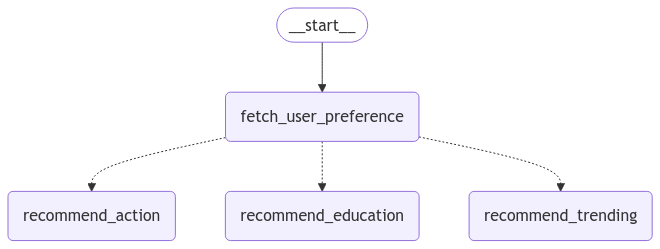

In [4]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))